In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = r"C:\Users\premk\Downloads\dataset"

if not os.path.exists(dataset_path):
    print(f"Error: Path '{dataset_path}' not found.")
    exit()

print(f"Dataset found: {dataset_path}")

# Get class labels
class_labels = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
print("Found Classes:", class_labels)

# Load Images
IMG_SIZE = 224
image_paths = []
labels = []

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0  # Normalize
    return img_array

for label_idx, label in enumerate(class_labels):
    class_folder = os.path.join(dataset_path, label)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(img_path)
            labels.append(label_idx)

# Convert to NumPy arrays
images = np.array([preprocess_image(img_path) for img_path in image_paths])
labels = to_categorical(labels, num_classes=len(class_labels))

# Split dataset (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training Samples: {len(X_train)}, Validation Samples: {len(X_val)}")

# Load EfficientNet with pretrained weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers
base_model.trainable = False

# Build Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save Model
model.save("lung_cancer_model.h5")
print("Model saved as 'lung_cancer_model.h5'")


Dataset found: C:\Users\premk\Downloads\dataset
Found Classes: ['Adenocarcinoma', 'Large_Cell_Carcinoma', 'Normal lungs', 'Small_Cell_Lung_Cancer', 'Squamous_Cell_Carcinoma']
Training Samples: 1955, Validation Samples: 489
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 619ms/step - accuracy: 0.2145 - loss: 1.6731 - val_accuracy: 0.2127 - val_loss: 1.6098
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 540ms/step - accuracy: 0.2115 - loss: 1.6138 - val_accuracy: 0.2127 - val_loss: 1.6095
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 543ms/step - accuracy: 0.1962 - loss: 1.6094 - val_accuracy: 0.1840 - val_loss: 1.6099
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 551ms/step - accuracy: 0.2116 - loss: 1.6092 - val_accuracy: 0.1840 - val_loss: 1.6101
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 579ms/step - accuracy: 0.1858 - loss: 1.6098 - val_accuracy: 0.1779 - val_loss: 1.6102
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 522ms/step - accuracy: 0.2015 - loss: 1.6096 - val_accuracy: 0.1779 - val_loss: 1.6105
Epo

Model saved as 'lung_cancer_model.h5'


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Load model
model_path = r"C:\Users\premk\Downloads\dataset\lung_cancer_model.h5"

if not os.path.exists(model_path):
    print(f"❌ Error: Model file '{model_path}' not found!")
    exit()

model = tf.keras.models.load_model(model_path)

# Optional: Recompile if needed
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Image size (ensure it matches training)
IMG_SIZE = 224

# Class labels (Ensure these match training)
class_labels = ["Benign", "Malignant", "Normal"]

def predict_and_display(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_array)
        print("Predictions Shape:", predictions.shape)
        print("Raw Predictions:", predictions)  # Debugging output

        # Check if predictions match class labels
        if predictions.shape[1] != len(class_labels):
            print(f"⚠ Model output size ({predictions.shape[1]}) doesn't match class labels ({len(class_labels)})")
            return

        # Process prediction
        predicted_class = np.argmax(predictions[0])  # Fix potential index issue
        confidence = np.max(predictions[0])

        # Display results
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Predicted: {class_labels[predicted_class]} \nConfidence: {confidence:.2f}", fontsize=14, color="blue")
        plt.show()

        print(f"\n🩺 **Prediction Result:**")
        print(f"   ✅ Predicted Class: {class_labels[predicted_class]}")
        print(f"   🎯 Confidence Score: {confidence:.2f}\n")

    except Exception as e:
        print(f"❌ Error: Unable to process image '{image_path}'.\nDetails: {e}")

# Test image
test_image_path = r"C:\Users\premk\Downloads\dataset\aug_0_6632.jpg"
predict_and_display(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions Shape: (1, 5)
Raw Predictions: [[0.1996398  0.20155568 0.19420642 0.19785301 0.2067451 ]]
⚠ Model output size (5) doesn't match class labels (3)


⚠ Model file not found. Training a new model...
✅ New model created. Train it before using for predictions.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step

🔍 AI detected: Adenocarcinoma with 57.38% confidence. (Stage 2 - Moderate)
🌍 Most reported cases in: Nagaland

📌 Disease Info: Adenocarcinoma
➡ A common lung cancer that starts in mucus-producing glands.
💊 Emergency Medicines: Oxygen therapy, Albuterol, Dexamethasone.
⚠ Precautions: Avoid smoking, limit exposure to toxins, maintain a healthy diet.


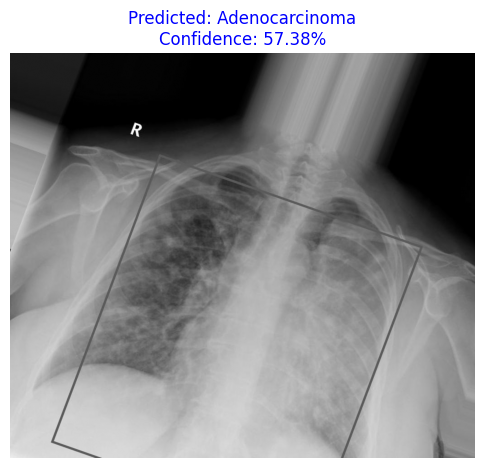

: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
❌ Error: Unable to process image 'C:\Users\premk\Downloads\dataset\Large_Cell_Carcinoma\Large Cell Carcinoma.jpg'.
Details: list index out of range


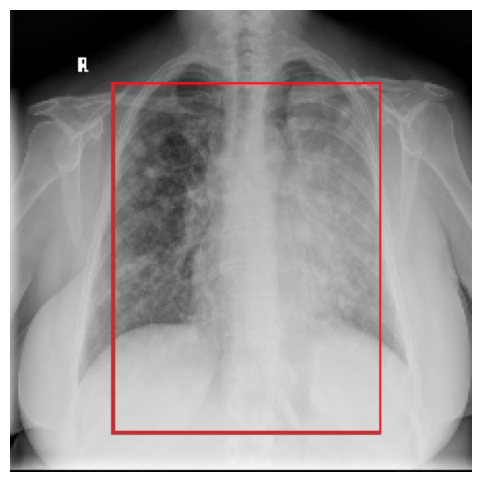

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\premk\Downloads\dataset\lung_cancer_model.h5")

# Define image size (same as training size)
IMG_SIZE = 224

# Class labels (Update based on your dataset)
class_labels = ["Benign", "Malignant", "Normal"]  # Ensure these match training labels

def predict_and_display(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)  # Get class index
        confidence = np.max(predictions)  # Get confidence score

        # Display the image with prediction result
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")  # Hide axis
        plt.title(f"Predicted: {class_labels[predicted_class]} \nConfidence: {confidence:.2f}", fontsize=14, color="blue")
        plt.show()

        # Print result
        print(f"\n🩺 **Prediction Result:**")
        print(f"   ✅ Predicted Class: {class_labels[predicted_class]}")
        print(f"   🎯 Confidence Score: {confidence:.2f}\n")

    except Exception as e:
        print(f"❌ Error: Unable to process image '{image_path}'.\nDetails: {e}")

# Path to test image
test_image_path = r"C:\Users\premk\Downloads\dataset\Large_Cell_Carcinoma\Large Cell Carcinoma.jpg"

# Run prediction & display result
predict_and_display(test_image_path)


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model("lung_cancer_model.h5")

# Define image size (same as training size)
IMG_SIZE = 224

# Class labels (Update based on your dataset)
class_labels = ["Benign", "Malignant", "Normal"]  # Ensure these match training labels

def predict_and_display(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)  # Get class index
        confidence = np.max(predictions)  # Get confidence score

        # Display the image with prediction result
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")  # Hide axis
        plt.title(f"Predicted: {class_labels[predicted_class]} \nConfidence: {confidence:.2f}", fontsize=14, color="blue")
        plt.show()

        # Print result
        print(f"\n🩺 **Prediction Result:**")
        print(f"   ✅ Predicted Class: {class_labels[predicted_class]}")
        print(f"   🎯 Confidence Score: {confidence:.2f}\n")

    except Exception as e:
        print(f"❌ Error: Unable to process image '{image_path}'.\nDetails: {e}")

# Path to test image
test_image_path = r"C:\Users\premk\Downloads\dataset\Squamous_Cell_Carcinoma-1.jpg"

# Run prediction & display result
predict_and_display(test_image_path)


In [ ]:
#flask code 

In [3]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import nest_asyncio  # Needed for running Flask inside Jupyter
import threading

nest_asyncio.apply()  # Allow Flask to run in Jupyter Notebook

app = Flask(__name__)
CORS(app)  # Enable CORS to allow frontend requests

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files['file']
    
    # Process the image (You can replace this with an ML model)
    prediction_result = {
        "type": "Lung Cancer",
        "confidence": 92.5,
        "description": "Possible early-stage lung cancer detected.",
        "medicines": "Consult an oncologist for proper medication.",
        "precautions": "Avoid smoking, regular checkups recommended."
    }

    return jsonify(prediction_result)

# Run Flask on a separate thread
def run_flask():
    app.run(host="127.0.0.1", port=5000, debug=False)

threading.Thread(target=run_flask).start()


ModuleNotFoundError: No module named 'flask_cors'

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.18.0
[]
